In [17]:
import pandas as pd
import numpy as np
import os
import random

import warnings

warnings.filterwarnings(action='ignore')

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [18]:
path = '/opt/ml/input/data/'
# # train = pd.read_csv(path + 'train_data.csv')
# # test = pd.read_csv(path + 'test_data.csv')
dat = pd.read_csv(path + 'FE/FE_total4.csv')

dat = dat.sort_values(by = ['userID', 'Timestamp'])
dat['tem'] = 0

_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] == -1]

In [19]:
class elo():
    def __init__(self):
        self.item_parameters = None
        self.student_parameters = None

    def get_new_theta(self,is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + self.learning_rate_theta(nb_previous_answers) * (
            is_good_answer - self.probability_of_good_answer(theta, beta, left_asymptote)
        )

    def get_new_beta(self,is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - self.learning_rate_beta(nb_previous_answers) * (
            is_good_answer - self.probability_of_good_answer(theta, beta, left_asymptote)
        )

    def learning_rate_theta(self,nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    def learning_rate_beta(self,nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    def probability_of_good_answer(self,theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * self.sigmoid(theta - beta)

    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def estimate_parameters(self,answers_df, granularity_feature_name="assessmentItemID"):
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(
                answers_df[granularity_feature_name]
            )
        }
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print("Parameter estimation is starting...", flush=True)

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            ),
            total=len(answers_df),
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = self.get_new_beta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = self.get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        self.student_parameters = student_parameters
        self.item_parameters = item_parameters
        return student_parameters, item_parameters
    
    def estimate_student_parameters(self,answers_df, granularity_feature_name="assessmentItemID"):
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        #print("Parameter estimation is starting...", flush=True)

        for student_id, item_id, left_asymptote, answered_correctly in zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            ):
            theta = student_parameters[student_id]["theta"]
            beta = self.item_parameters[item_id]["beta"]

            student_parameters[student_id]["theta"] = self.get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

           
            student_parameters[student_id]["nb_answers"] += 1

        #print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        self.student_parameters = student_parameters
        return student_parameters

    def update_parameters(self,answers_df, student_parameters, item_parameters, granularity_feature_name='assessmentItemID'):
        for student_id, item_id, left_asymptote, answered_correctly in zip(
            answers_df.userID.values, 
            answers_df[granularity_feature_name].values, 
            answers_df.left_asymptote.values, 
            answers_df.answerCode.values):
            if student_id not in student_parameters:
                student_parameters[student_id] = {'theta': 0, 'nb_answers': 0}
            if item_id not in item_parameters:
                item_parameters[item_id] = {'beta': 0, 'nb_answers': 0}
                
            theta = student_parameters[student_id]['theta']
            beta = item_parameters[item_id]['beta']

            student_parameters[student_id]['theta'] = self.get_new_theta(
                answered_correctly, beta, left_asymptote, theta, student_parameters[student_id]['nb_answers']
            )
            item_parameters[item_id]['beta'] = self.get_new_beta(
                answered_correctly, beta, left_asymptote, theta, item_parameters[item_id]['nb_answers']
            )
            
            student_parameters[student_id]['nb_answers'] += 1
            item_parameters[item_id]['nb_answers'] += 1
        
        
        return student_parameters, item_parameters
    def run(self,df):
        df["left_asymptote"] = 0

        print(f"Dataset of shape {df.shape}")
        print(f"Columns are {list(df.columns)}")
        
        student_parameters, item_parameters = self.estimate_parameters(df)

        t = [
            student_parameters[student]["theta"]
            for student, item in zip(df.userID.values, df.assessmentItemID.values)
        ]
        
        return t 
    
    def run_update(self,df):
        df["left_asymptote"] = 0
        return self.estimate_student_parameters(df)[df.iloc[0,0]]['theta']

In [20]:
# 데이터 증강하는 법.
def data_argument(train):
    _train = train.copy()
    _train.reset_index(drop = True, inplace= True)
    _train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'tem'] = -1
    _valid = _train[_train['tem'] == -1]
    _train = _train[_train['tem'] == 0]

    return _train, _valid

_train_x, _valid = data_argument(_train)

Elo = elo()
_ = Elo.run(_train_x) #
item = _train_x.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum']) #
item.columns = ["item_mean", 'item_sum']
item.reset_index(inplace = True)
item2 = _train_x.groupby(['assessmentItemID'])['solve_time'].agg(['mean']) # 
item2.columns = ['solve_time_mean']
item2.reset_index(inplace = True)
item_df = pd.merge(item,item2)
item_df['elo'] = item_df['assessmentItemID'].map(Elo.item_parameters)
item_df['beta'] = item_df['elo'].apply(lambda x : x['beta'])
item_df.head()

Dataset of shape (2518514, 26)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'solve_time', 'b_category', 'test_category', 'problem_id', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'last_answerCode7', 'last_answerCode8', 'last_answerCode9', 'last_answerCode10', 'year', 'month', 'day', 'hour', 'tem', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 2518514/2518514 [00:18<00:00, 138873.24it/s]


Theta & beta estimations on assessmentItemID are completed.


,assessmentItemID,item_mean,item_sum,solve_time_mean,elo,beta
0,A010001001,0.922857,323,21.231429,"{'beta': -2.339647734731408, 'nb_answers': 350}",-2.339648
1,A010001002,0.960000,336,22.260000,"{'beta': -2.8010620501108012, 'nb_answers': 350}",-2.801062
2,A010001003,0.905714,317,16.245714,"{'beta': -2.0866955633614523, 'nb_answers': 350}",-2.086696
3,A010001004,0.945714,331,30.462857,"{'beta': -2.559716430924332, 'nb_answers': 350}",-2.559716
4,A010001005,0.882857,309,37.520000,"{'beta': -1.7407733070946627, 'nb_answers': 350}",-1.740773


In [21]:
def data_merge(_train_x, _train_y): 
    # _train_x : 값 제공하는 전체 DB, _train_y : 현재 맞춰야 하는 유저와 아이템 상태.

    # 유저가 푼 아이템에 정보 입력해주기.
    _train_x = pd.merge(_train_x, item_df[['assessmentItemID','item_mean','beta']], on=['assessmentItemID'], how='left')

    # 유저 단위 변수 추가
    # 유저가 평균적으로 얼마나 맞는지, 또 몇 문제 풀었는지.
    tem1 = _train_x.groupby('userID')['answerCode']
    tem1 = pd.DataFrame({'answer_mean' : tem1.mean(), 'answer_cnt':tem1.count()}).reset_index()
    # 유저가 평균적으로 몇 분안에 문제를 풀었는지.
    tem2 = _train_x.groupby('userID')['solve_time']
    tem2 = pd.DataFrame({'time_mean' : tem2.mean()}).reset_index()
    # 유저의 태그를 붙인 것 같은데 정확히 뭔지 모르겠음. => 최빈 태그라고 함(mode)
    tem3 = pd.DataFrame({'tag_mode' : _train_x.groupby('userID')['KnowledgeTag'].agg(pd.Series.mode)})
    tem3['tag_mode'] = tem3['tag_mode'].apply(lambda x : x if str(type(x)) =="<class 'numpy.int64'>" else x[0])
    # 유저가 지금까지 푼 문제의 평균 정답률은 어떻게 되는지 구하기.(어려운 문제를 풀어왔는가?)
    tem5 = _train_x.groupby(['userID'])['item_mean'].agg(['mean']).reset_index()
    tem5.columns = ["userID", 'user_item_mean']
    tem6 = _train_x.groupby(['userID'])['beta'].agg(['mean']).reset_index()
    tem6.columns = ["userID", 'user_item_beta']
    # 유저의 elo 측정.
    tem7 = pd.DataFrame(_train.groupby(['userID']).apply(lambda x : Elo.run_update(x)))
    tem7.reset_index(inplace = True)
    tem7.columns = ['userID', 'user_elo']

    user_df = pd.merge(tem1, tem2, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem3, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem5, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem6, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem7, on=['userID'], how='left')
    # user_df = pd.merge(user_df, tem4, on=['userID'], how='left')

    _train_y = pd.merge(_train_y[['userID', 'assessmentItemID', 'answerCode','last_answerCode',
    'last_answerCode2','last_answerCode3','last_answerCode4','last_answerCode5','last_answerCode6',
    'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10']], user_df, on=['userID'], how='left')

    # 아이템 단위 변수 추가.

    # 해당 문제는 평균 정답률이, elo, 문제풀이시간 어떻게 되는가? + 학생이 몇 번이나 풀었던가?
    _train_y = pd.merge(_train_y, item_df.drop(['elo'], axis = 1), on=['assessmentItemID'], how='left')

    return _train_y.drop(['userID','assessmentItemID'],axis=1)

test = data_merge(_train, _test)
valid = data_merge(_train_x, _valid)

In [22]:
_train_x_1, _train_1 = data_argument(_train_x)
train_1 = data_merge(_train_x_1, _train_1)
train = train_1.copy()

for _ in tqdm(range(3)):
    _train_x_1, _train_1 = data_argument(_train_x_1)
    train_1 = data_merge(_train_x_1, _train_1)
    train = pd.concat([train, train_1])

train = train[train['answer_cnt'] >= 14]

100%|██████████| 3/3 [01:03<00:00, 21.09s/it]


In [16]:
#!pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import gc


def objective(trial, train, valid, train_value, valid_value):
    
    param = {
    #"task_type" : "GPU",
    #"eval_metric" : 'AUC',
    "devices" : 'gpu',
    'random_state' : 1998,
    'learning_rate': 0.005,#trial.suggest_loguniform('learning_rate', 0.01, 0.05),
    #'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 0.1),
    'n_estimators' : 4000, #trial.suggest_int("iterations", 500, 2000),
    'max_depth': trial.suggest_int("max_depth", 8, 12),
    'num_leaves': trial.suggest_int("num_leaves", 40, 120),
    #'random_strength': trial.suggest_int("random_strength", 15, 45),
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 0.1),
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 0.1),
    #"colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
    'min_child_samples': trial.suggest_int("min_child_samples", 64, 128), 
    'subsample': 0.4,
    #'max_bin': trial.suggest_int("max_bin", 300, 400), 
    }

    
    model = LGBMClassifier(**param)
    model.fit(train, train_value, eval_metric = 'AUC',
    eval_set=(valid, valid_value), verbose=200)
    
    print('train score')
    train_pred = model.predict_proba(train)[:,1]
    print(roc_auc_score(train_value, train_pred)) # auc
    print(accuracy_score(train_value, np.where(train_pred >= 0.5, 1, 0))) # acc, 정확도

    print('valid score')
    valid_pred = model.predict_proba(valid)[:,1]
    print(roc_auc_score(valid_value, valid_pred)) # auc
    print(accuracy_score(valid_value, np.where(valid_pred >= 0.5, 1, 0))) # acc, 정확도

    gc.collect()

    return roc_auc_score(valid_value, valid_pred)


sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(lambda trial : objective(trial, train.drop(['answerCode'],axis=1), valid.drop(['answerCode'],axis=1), train['answerCode'], valid['answerCode']), n_trials=10)

[I 2022-12-08 05:08:48,958] A new study created in memory with name: cat_parameter_opt


[LightGBM] [Warning] Unknown parameter: devices
[200]	valid_0's auc: 0.811469	valid_0's binary_logloss: 0.563923
[400]	valid_0's auc: 0.81539	valid_0's binary_logloss: 0.532046
[600]	valid_0's auc: 0.817667	valid_0's binary_logloss: 0.523925
[800]	valid_0's auc: 0.819103	valid_0's binary_logloss: 0.521215
[1000]	valid_0's auc: 0.820455	valid_0's binary_logloss: 0.519442
[1200]	valid_0's auc: 0.821262	valid_0's binary_logloss: 0.518507
[1400]	valid_0's auc: 0.821686	valid_0's binary_logloss: 0.518006
[1600]	valid_0's auc: 0.821833	valid_0's binary_logloss: 0.517862
[1800]	valid_0's auc: 0.821847	valid_0's binary_logloss: 0.517876
[2000]	valid_0's auc: 0.821875	valid_0's binary_logloss: 0.517892
[2200]	valid_0's auc: 0.821944	valid_0's binary_logloss: 0.517859
[2400]	valid_0's auc: 0.822053	valid_0's binary_logloss: 0.517751
[2600]	valid_0's auc: 0.822137	valid_0's binary_logloss: 0.517675
[2800]	valid_0's auc: 0.822124	valid_0's binary_logloss: 0.517748
[3000]	valid_0's auc: 0.822054	va

[I 2022-12-08 05:11:24,203] Trial 0 finished with value: 0.821669242946634 and parameters: {'max_depth': 9, 'num_leaves': 117, 'reg_alpha': 0.001330324510152289, 'reg_lambda': 0.00015509913987594285, 'min_child_samples': 74}. Best is trial 0 with value: 0.821669242946634.


[LightGBM] [Warning] Unknown parameter: devices
[200]	valid_0's auc: 0.808174	valid_0's binary_logloss: 0.569429
[400]	valid_0's auc: 0.812686	valid_0's binary_logloss: 0.536423
[600]	valid_0's auc: 0.815417	valid_0's binary_logloss: 0.527163
[800]	valid_0's auc: 0.817726	valid_0's binary_logloss: 0.523068
[1000]	valid_0's auc: 0.819616	valid_0's binary_logloss: 0.520491
[1200]	valid_0's auc: 0.820693	valid_0's binary_logloss: 0.519136
[1400]	valid_0's auc: 0.821268	valid_0's binary_logloss: 0.518395
[1600]	valid_0's auc: 0.821553	valid_0's binary_logloss: 0.518014
[1800]	valid_0's auc: 0.821758	valid_0's binary_logloss: 0.517769
[2000]	valid_0's auc: 0.821973	valid_0's binary_logloss: 0.517498
[2200]	valid_0's auc: 0.822158	valid_0's binary_logloss: 0.517304
[2400]	valid_0's auc: 0.822206	valid_0's binary_logloss: 0.517233
[2600]	valid_0's auc: 0.822244	valid_0's binary_logloss: 0.517184
[2800]	valid_0's auc: 0.822321	valid_0's binary_logloss: 0.517134
[3000]	valid_0's auc: 0.822389	v

[I 2022-12-08 05:12:54,275] Trial 1 finished with value: 0.8226149751214978 and parameters: {'max_depth': 8, 'num_leaves': 44, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298, 'min_child_samples': 110}. Best is trial 1 with value: 0.8226149751214978.


[LightGBM] [Warning] Unknown parameter: devices
[200]	valid_0's auc: 0.811568	valid_0's binary_logloss: 0.563908
[400]	valid_0's auc: 0.815307	valid_0's binary_logloss: 0.532042
[600]	valid_0's auc: 0.817389	valid_0's binary_logloss: 0.524121
[800]	valid_0's auc: 0.818823	valid_0's binary_logloss: 0.521423
[1000]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.519639
[1200]	valid_0's auc: 0.82094	valid_0's binary_logloss: 0.518729
[1400]	valid_0's auc: 0.821451	valid_0's binary_logloss: 0.51814


[W 2022-12-08 05:14:15,745] Trial 2 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/opt/conda/envs/ksy/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_13403/3582594209.py", line 55, in <lambda>
    study.optimize(lambda trial : objective(trial, train.drop(['answerCode'],axis=1), valid.drop(['answerCode'],axis=1), train['answerCode'], valid['answerCode']), n_trials=10)
  File "/tmp/ipykernel_13403/3582594209.py", line 31, in objective
    model.fit(train, train_value, eval_metric = 'AUC',
  File "/opt/conda/envs/ksy/lib/python3.10/site-packages/lightgbm/sklearn.py", line 890, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/opt/conda/envs/ksy/lib/python3.10/site-packages/lightgbm/sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "/opt/conda/envs/ksy/l

[1600]	valid_0's auc: 0.821642	valid_0's binary_logloss: 0.517943


KeyboardInterrupt: 

In [23]:
model = LGBMClassifier(random_state=1998, n_estimators=3500, learning_rate=0.005, subsample = 0.4 ,max_depth=11,
reg_lambda = 0.001, reg_alpha = 1e-6, min_child_samples = 128, num_leaves = 50)
model.fit(train.drop(['answerCode'],axis=1), train['answerCode'], eval_metric = 'AUC',
eval_set=(valid.drop(['answerCode'],axis=1), valid['answerCode']), verbose=200)
preds = model.predict_proba(train.drop(['answerCode'],axis=1))[:,1]

acc = accuracy_score(train['answerCode'], np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(train['answerCode'], preds)
print(f'TRAIN AUC : {auc} ACC : {acc}\n')

preds = model.predict_proba(valid.drop(['answerCode'],axis=1))[:,1]
acc = accuracy_score(valid['answerCode'], np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(valid['answerCode'], preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
# train 대비 Valid가 낮다. valid는 리더보드와 거의 동일하다.
# train에 모델 과적합. => 과적합 방지 하이퍼파라미터 튜닝 + 데이터 증강필요?

[200]	valid_0's auc: 0.813026	valid_0's binary_logloss: 0.56247
[400]	valid_0's auc: 0.816824	valid_0's binary_logloss: 0.530579
[600]	valid_0's auc: 0.819208	valid_0's binary_logloss: 0.522497
[800]	valid_0's auc: 0.822132	valid_0's binary_logloss: 0.518209
[1000]	valid_0's auc: 0.824289	valid_0's binary_logloss: 0.515591
[1200]	valid_0's auc: 0.82544	valid_0's binary_logloss: 0.514416
[1400]	valid_0's auc: 0.826031	valid_0's binary_logloss: 0.514013
[1600]	valid_0's auc: 0.826393	valid_0's binary_logloss: 0.513835
[1800]	valid_0's auc: 0.82658	valid_0's binary_logloss: 0.513925
[2000]	valid_0's auc: 0.826453	valid_0's binary_logloss: 0.514457
[2200]	valid_0's auc: 0.826565	valid_0's binary_logloss: 0.514665
[2400]	valid_0's auc: 0.826392	valid_0's binary_logloss: 0.515228
[2600]	valid_0's auc: 0.826268	valid_0's binary_logloss: 0.515736
[2800]	valid_0's auc: 0.825957	valid_0's binary_logloss: 0.516523
[3000]	valid_0's auc: 0.825811	valid_0's binary_logloss: 0.517165
[3200]	valid_0's 

Text(0.5, 1.0, 'Feature Importance')

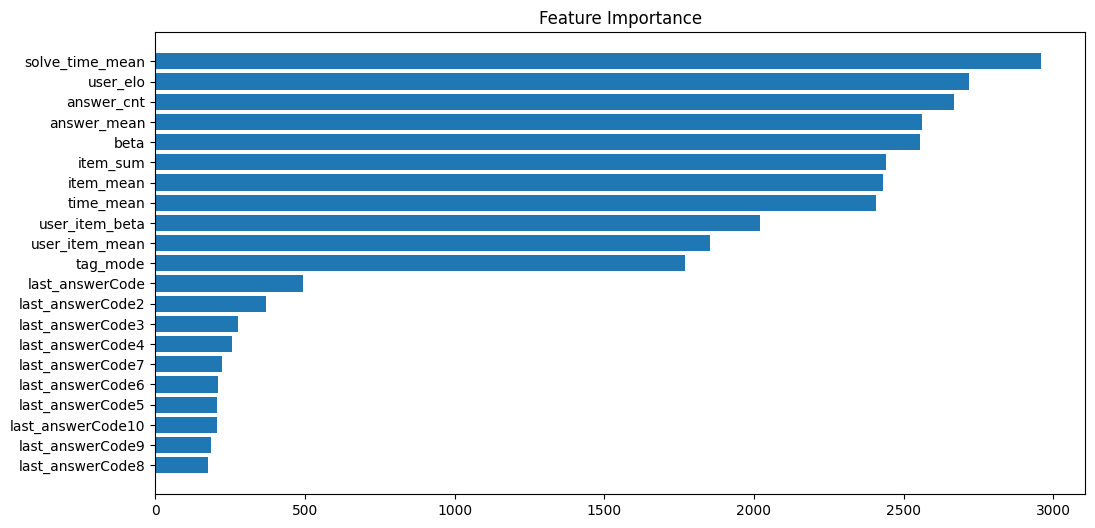

In [109]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(valid.drop(['answerCode'],axis=1).columns)[sorted_idx])
plt.title("Feature Importance")

In [10]:
# submission 제출하기 위한 코드

test_pred = model.predict_proba(test.drop(['answerCode'],axis=1))[:,1]
test['prediction'] = test_pred
submission = test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/sequence_50LGBM_solve100.csv', index = False)

ValueError: Number of features of the model must match the input. Model n_features_ is 18 and input n_features is 19 